#### Important Links (for attribute and database reference):

https://datasus.saude.gov.br/mortalidade-desde-1996-pela-cid-10

https://renastonline.ensp.fiocruz.br/sites/default/files/wiki/dicionario-sim.pdf

https://diaad.s3.sa-east-1.amazonaws.com/sim/Mortalidade_Geral+-+Estrutura.pdf

https://svs.aids.gov.br/download/Dicionario_de_Dados_SIM_tabela_DO.pdf

http://tabnet.datasus.gov.br/cgi/sim/Mortalidade_Geral_1996_2012.pdf

http://tabnet.datasus.gov.br/cgi/sim/Consolida_Sim_2011.pdf

ICD10 suicide codes used by DATASUS:

Códigos de suicídio usados pelo DATASUS do CID10:
http://www2.datasus.gov.br/cid10/V2008/WebHelp/v01_y98.htm#Cap20Nota01

#### DATASUS DATA:
```
ftp.datasus.gov.br
    /dissemin/publicos/SIM/CID10/DORES
    /dissemin/publicos/SIM/CID10/DOCS
```
Usual year update date:

![image.jpg](../utils/attrs-utils/attrs-info/imgs/datasus_year_update_date.jpg)

In [1]:
# Importações
from IPython.display import display

import pandas as pd

import numpy as np
import datetime

import matplotlib.pyplot as plt

# if automatic converters are necessary
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Prevent infinite warnings
import warnings
warnings.filterwarnings('ignore')

# OS and File imports
import os
from zipfile import ZipFile
from io import BytesIO

import sys

# List of directories to add to sys.path
directories_to_add = [
    os.path.abspath(os.path.join('..')),
    os.path.abspath(os.path.join('..', 'utils')),
]

for directory in directories_to_add:
    if directory not in sys.path:
        sys.path.insert(0, directory)

from utils.functions.color_palettes import my_blue, my_orange

## Files Location Setup

Folder structure:
```
root_folder/
    data_storage/
        attrs-utils/"relevant_attributes_infos"
        datasus/"all years csvs"
        utils/"utility functions and data"
    data_creation/
        0_Datasus_data_reader_v2.ipynb
        1_Datasus_merger_to_csv.ipynb
        2_Data_modeling.ipynb
        3_Data_preprocessing.ipynb
    plots/all_generated_plots...
```

### User set folder path:

In [2]:
# ---------------- USER SET FOLDER PATH ----------------
user_folder_path = ''

root_dir = '..'

final_dataset_dir = '/BrSuicides/'
final_dataset_name = 'BrSuicides'

csv_dir = '/data_storage/'
# csv_dir_datasus = csv_dir + '0_datasus_csvs/'
csv_dir_dirty = csv_dir + '1_dirty/'

csv_dir_clean = final_dataset_dir + '/'

csv_data_dir = os.path.dirname(root_dir + csv_dir) + '/'
print(csv_data_dir)

# datasus_data_dir = os.path.dirname(root_dir + csv_dir_datasus) + '/'
# print(datasus_data_dir)
csv_data_dir_dirty = os.path.dirname(root_dir + csv_dir_dirty) + '/'
print(csv_data_dir_dirty)
csv_data_dir_clean = os.path.dirname(root_dir + csv_dir_clean) + '/'
print(csv_data_dir_clean)


../data_storage/
../data_storage/1_dirty/
../BrSuicides/


This code is specific for Data_modeling:

In [3]:
# List all files in the csvs directory
all_files = os.listdir(csv_data_dir_dirty)

# Filter for files that end with .zip extension
csv_files = [file for file in all_files if file.endswith('.csv')]
print('CSVs: ', '\n', csv_files)

# Filter for files that end with .zip extension
csv_file_name = csv_files[0]
print('CSV file name: ', '\n', csv_file_name)

# Get region name
region_name = csv_files[0].split('-')[1]
print('Region name: ', '\n', region_name)

years_interval = csv_files[0].split('-')[2][0:-4].split('_')
print('Years interval: ', '\n' , years_interval)

# Years that will be downloaded, [1996,2023) interval
years = [x for x in range(int(years_interval[0]), (int(years_interval[-1]) + 1))]
# years = [1996, 1997, 1998, 1999, 2000, 2001, 2002, 
#          2003, 2004, 2005, 2006, 2007, 2008, 2009, 
#          2010, 2011, 2012, 2013, 2014, 2015, 2016, 
#          2017, 2018, 2019, 2020, 2021, 2022, 
#        # 2023
#          ]

print('Years:', '\n', years)

CSVs:  
 ['suicidios-brazil-1996_2022.csv']
CSV file name:  
 suicidios-brazil-1996_2022.csv
Region name:  
 brazil
Years interval:  
 ['1996', '2022']
Years: 
 [1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [4]:
# folder_location: datasus_data_dir_cleaned
def save_cleaned_df_sep_by_years(df, year_col, folder_location):
    os.makedirs(folder_location, exist_ok=True)
    unique_years = df[year_col].unique()
    
    for year in unique_years:
        year_df = df[df[year_col] == year]
        if not year_df.empty:
            file_path = os.path.join(folder_location, f'{year}.csv')
            year_df.to_csv(file_path, index=False)
            print(f"Saved {file_path}")

### Dataframe:

### Como os dados são coletados e sua granularidade:

As Secretarias de Saúde coletam as Declarações de Óbitos dos cartórios e entram, no SIM, as informações nelas contidas. Uma das informações primordiais é a causa básica de óbito, a qual é codificada a partir do declarado pelo médico atestante, segundo regras estabelecidas pela Organização Mundial de Saúde. A partir de 1996, as declarações de óbito passaram a ser codificadas utilizando-se a 10ª Revisão da Classificação Internacional de Doenças - CID-10. Até então, era utilizada a 9ª Revisão - CID-9. Devido às diferenças entre as revisões, não foi possível gerar uma lista que as compatibilizasse.

De uma maneira geral, as Secretarias Municipais e Estaduais de Saúde enviam periodicamente a sua Base de Dados para o Ministério da Saúde. Este só pode considerar a Base Nacional completa quando todas as UF enviaram seus dados. A partir daí, é feita a consolidação, inclusive com a redistribuição dos óbitos pelo local de residência, a qual é a forma tradicional de apresentar os dados de Mortalidade. Eventualmente, são feitas algumas correções nas informações, em conjunto com as Secretarias Municipais e Estaduais, principalmente quanto ao cruzamento de causa de óbito por sexo e idade.

### How the data is collected and their granularity:

The Health Departments collect Death Certificates from the registry offices and enter the information into the Mortality Information System (SIM). One of the primary pieces of information is the underlying cause of death, which is coded based on what the certifying physician declares, following rules established by the World Health Organization. Since 1996, death certificates have been coded using the 10th Revision of the International Classification of Diseases (ICD-10). Prior to that, the 9th Revision (ICD-9) was used. Due to differences between the revisions, it was not possible to generate a list that made them compatible.

Generally, Municipal and State Health Departments periodically send their databases to the Ministry of Health. The National Database can only be considered complete when all the states have submitted their data. From there, consolidation is done, including the redistribution of deaths by place of residence, which is the traditional way to present Mortality data. Occasionally, some corrections are made to the information, in conjunction with the Municipal and State Health Departments, especially concerning the cross-referencing of cause of death by sex and age.

Referência / Reference:
http://tabnet.datasus.gov.br/cgi/sim/Mortalidade_Geral_1996_2012.pdf


In [5]:
dataframe = pd.read_csv(csv_data_dir_dirty + csv_file_name, encoding='utf-8')
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268028 entries, 0 to 268027
Columns: 103 entries, ESTADO to ALTCAUSA
dtypes: float64(3), int64(6), object(94)
memory usage: 210.6+ MB


In [6]:
dataframe_columns = list(dataframe.columns)

print('Dataframe columns:\n', dataframe_columns)
print('\nNº of columns in dataframe: ', len(dataframe_columns))

Dataframe columns:
 ['ESTADO', 'ANO', 'level_2', 'contador', 'TIPOBITO', 'DTOBITO', 'NATURAL', 'DTNASC', 'IDADE', 'SEXO', 'RACACOR', 'ESTCIV', 'ESC', 'OCUP', 'CODBAIRES', 'CODMUNRES', 'LOCOCOR', 'CODMUNOCOR', 'IDADEMAE', 'ESCMAE', 'OCUPMAE', 'QTDFILVIVO', 'QTDFILMORT', 'GRAVIDEZ', 'GESTACAO', 'PARTO', 'OBITOPARTO', 'PESO', 'OBITOGRAV', 'OBITOPUERP', 'ASSISTMED', 'EXAME', 'CIRURGIA', 'NECROPSIA', 'CAUSABAS', 'LINHAA', 'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII', 'CIRCOBITO', 'ACIDTRAB', 'FONTE', 'CODESTAB', 'ATESTANTE', 'UFINFORM', 'CONTADOR', 'HORAOBITO', 'CODBAIOCOR', 'TPASSINA', 'DTATESTADO', 'TPPOS', 'DTINVESTIG', 'CAUSABAS_O', 'DTCADASTRO', 'FONTEINV', 'DTRECEBIM', 'CB_PRE', 'NUMERODN', 'MORTEPARTO', 'TPOBITOCOR', 'ORIGEM', 'DTCADINF', 'DTCADINV', 'COMUNSVOIM', 'DTRECORIG', 'DTRECORIGA', 'CAUSAMAT', 'ESC2010', 'ESCMAE2010', 'STDOEPIDEM', 'STDONOVA', 'SEMAGESTAC', 'TPMORTEOCO', 'DIFDATA', 'DTCONCASO', 'NUDIASOBIN', 'SERIESCFAL', 'SERIESCMAE', 'CODMUNCART', 'CODCART', 'NUMREGCART', 'DTRE

In [7]:
# Attempts to convert a float to an int if the float is a whole number.
def float_to_int(x):
    if pd.isna(x):
        return x  # Keep NaN as is
    elif isinstance(x, float) and x.is_integer():
        # Convert floats that are whole numbers
        # to integers and then strings?????? it works though
        return str(int(x))  
    else:
        return x  # Return the original value

In [8]:
# Removing leading and trailing whitespaces
for col in dataframe:
    if dataframe[col].dtypes == object:
        if not pd.to_numeric(dataframe[col], errors='coerce').isnull().all() and col != "ESCFALAGR1":
            print(f'col: {col} is numeric')
            # Temporarily convert numbers to strings and strip whitespaces
            stripped = dataframe[col].astype(str).str.strip()
            # Replace empty strings with np.nan to identify real empty values
            cleaned = stripped.replace('', np.nan)
            # Attempt to convert back to numeric where possible, keep as string if not
            dataframe[col] = pd.to_numeric(cleaned, errors='coerce')
            dataframe[col] = dataframe[col].apply(float_to_int)
            
            # For entries that were just whitespace (now NaN), replace with empty strings
            dataframe[col] = dataframe[col].fillna('')
        else:
            print(f'col: {col} is not numeric')
            dataframe[col] = dataframe[col].str.strip()


col: ESTADO is not numeric
col: NATURAL is numeric
col: DTNASC is numeric
col: IDADE is numeric
col: SEXO is numeric
col: RACACOR is numeric
col: ESTCIV is numeric
col: ESC is numeric
col: OCUP is numeric
col: CODBAIRES is numeric
col: LOCOCOR is numeric
col: IDADEMAE is numeric
col: ESCMAE is numeric
col: OCUPMAE is numeric
col: QTDFILVIVO is numeric
col: QTDFILMORT is numeric
col: GRAVIDEZ is numeric
col: GESTACAO is numeric
col: PARTO is numeric
col: OBITOPARTO is numeric
col: PESO is numeric
col: OBITOGRAV is numeric
col: OBITOPUERP is numeric
col: ASSISTMED is numeric
col: EXAME is numeric
col: CIRURGIA is numeric
col: NECROPSIA is numeric
col: CAUSABAS is not numeric
col: LINHAA is not numeric
col: LINHAB is not numeric
col: LINHAC is not numeric
col: LINHAD is not numeric
col: LINHAII is not numeric
col: CIRCOBITO is numeric
col: ACIDTRAB is numeric
col: FONTE is numeric
col: CODESTAB is numeric
col: ATESTANTE is numeric
col: UFINFORM is numeric
col: HORAOBITO is numeric
col: CO

### Filtragem dos atributos para disponibilizar a base de dados

Como o objetivo de disponibilizar essa base de dados se dá no contexto de casos de suicídio, inúmeros atributos foram filtrados, por serem administrativos, como VERSAOSIST, que define a versão do sistema usado para registro do caso de óbito, ou atributos que não são relacionados com suicídio, como "TPMORTEOCO", que define a situação gestacional ou pósgestacional em que ocorreu o óbito, configurando um óbito que não condiz com as condições de um suicídio. A seguir estão documentados os atributos removidos e o motivo pela sua remoção:

### Filtering Attributes to Provide the Database

Since the purpose of providing this database is within the context of suicide cases, numerous attributes were filtered out due to being administrative, such as VERSAOSIST, which defines the system version used for recording the death case, or attributes that are not related to suicide, such as "TPMORTEOCO", which defines the gestational or post-gestational situation in which the death occurred, representing a death that does not align with the conditions of a suicide. Below are the documented attributes removed and the reason for their removal:

#### Date cleaning and standardization
The date attributes related to the time of birth and death will need cleaning regardless

In [9]:
def clean_dates_data(df, date_columns, remove_nans=True):
    # Atributos de data
    date_ats = date_columns

    # Check if the columns exist and convert them to datetime
    existing_date_columns = [col for col in date_ats if col in df.columns]

    n_of_entries_before_filtering = df.shape[0]

    # Convert the 'date' column to datetime and coerce errors
    for col in existing_date_columns:
        print(f'Column: {col}')
        print(f'Unstandardized date example:\n{df[col][0:2]}')
        df[col] = df[col].apply(lambda x: str(x)[0:-6] + "-" + str(x)[-6:-4] + "-" + str(x)[-4:] if x != '' else np.nan)
        df[col] = pd.to_datetime(df[col], errors='coerce', format="%d-%m-%Y")
        print(f'\nStandardized date example:\n{df[col][0:2]}\n')

    # Check for null percentage in all attributes, for all time
    nulls_pct_dates = df[existing_date_columns].isna().mean() * 100

    nulls_pct_dates_df = nulls_pct_dates.reset_index()
    nulls_pct_dates_df.columns = ['attribute', 'null_%']
    print('Percentage of missing values in dates:\n', nulls_pct_dates_df)

    # Find rows with null values in any of the date columns
    invalid_rows = df[df[existing_date_columns].isna().any(axis=1)]
    if remove_nans:
        df = df.dropna(subset=existing_date_columns)
        for col in existing_date_columns:
            print(f'Number of filtered {col} invalid rows: {len(invalid_rows)}\n')
            print(f'Example of filtered {col} invalid rows:\n{invalid_rows[col].head(5)}\n')
    else:
        for col in existing_date_columns:
            print(f'Number of unfiltered {col} invalid rows: {len(invalid_rows)}\n')

    return df

In [10]:
# Atributos de data de óbito
death_date_ats = ['DATAOBITO', 'DTOBITO']

# Check if the columns exist and convert them to datetime
valid_dtobito_df = clean_dates_data(df=dataframe, date_columns=death_date_ats)

Column: DTOBITO
Unstandardized date example:
0    24101996
1     4021996
Name: DTOBITO, dtype: int64

Standardized date example:
0   1996-10-24
1   1996-02-04
Name: DTOBITO, dtype: datetime64[ns]

Percentage of missing values in dates:
   attribute    null_%
0   DTOBITO  0.019401
Number of filtered DTOBITO invalid rows: 52

Example of filtered DTOBITO invalid rows:
197    NaT
1129   NaT
1167   NaT
2002   NaT
2070   NaT
Name: DTOBITO, dtype: datetime64[ns]



In [11]:
df_attrs_info = pd.read_csv(root_dir + '/utils/attrs-utils/attrs-info/datasus-attrs-info.csv')
print('Some info on the attributes from DATASUS:\n', df_attrs_info.head(4))
df_attrs_columns = list(df_attrs_info['name'])
print('\nColumns present in the pdfs:\n', df_attrs_columns)
print('\nNº of columns in dataframe: ', len(df_attrs_columns))

Some info on the attributes from DATASUS:
         name                                        description  year_added
0   ACIDTRAB  Indica se o evento que desencadeou o óbito est...        1979
1   ALTCAUSA  Indica se houve correção ou alteração da causa...        2014
2    AREARES                                                NaN        1979
3  ASSISTMED  Se refere ao atendimento médico continuado que...        1979

Columns present in the pdfs:
 ['ACIDTRAB', 'ALTCAUSA', 'AREARES', 'ASSISTMED', 'ATESTADO', 'ATESTANTE', 'BAIRES', 'CARTORIO', 'CAUSABAS', 'CAUSABAS_O', 'CAUSAMAT', 'CB_PRE', 'CIRCOBITO', 'CIRURGIA', 'CODBAIOCOR', 'CODBAIRES', 'CODCART', 'CODESTAB', 'CODIFICADO', 'CODIGO', 'CODMUNCART', 'CODMUNNATU', 'CODMUNOCOR', 'CODMUNRES', 'COMUNSVOIM', 'CONTADOR', 'CRITICA', 'CRM', 'CRSOCOR', 'CRSRES', 'DATANASC', 'DATAOBITO', 'DATAREG', 'DIFDATA', 'DTATESTADO', 'DTCADASTRO', 'DTCADINF', 'DTCADINV', 'DTCONCASO', 'DTCONINV', 'DTINVESTIG', 'DTNASC', 'DTOBITO', 'DTRECEBIM', 'DTRECORIG'

### Dicionário de conversões de valores para os atributos:

De acordo com a referência, estes são todos os atributos que necessitam de uma tabela de conversão de valores nominais para descritivos, com as informações relevantes de nome do atributo, sua descrição, e ano inicial de inclusão:

Os atributos comentados são atributos filtrados futuramente, removidos agora para reduzir o tamanho do dicionário.

### Dictionary of Value Conversions for Attributes:
According to the reference, these are all the attributes that require a conversion table from nominal to descriptive values, with relevant information about the attribute name, its description, and the starting year of inclusion:

The commented attributes are those that will be filtered out in the future, removed now to reduce the size of the dictionary.

Referência / Reference:
https://diaad.s3.sa-east-1.amazonaws.com/sim/Mortalidade_Geral+-+Estrutura.pdf

In [12]:
from utils.functions.conversion_dict import get_conversion_dict

conversion_dict = get_conversion_dict()

print('Possible nº of categorical data needing conversion: ', len(conversion_dict.keys()))

Possible nº of categorical data needing conversion:  20


In [13]:
def check_missing_keys(df, c_dict):
    # Get value counts for each column in the df
    value_counts_dict = {col: df[col].value_counts().to_dict() for col in df.columns if col in c_dict}
    # To check later if the cols were filtered out
    missing_keys_columns = []
    # Checks for keys in the dataset that don't exist in the conversion dictionary
    for col, counts in value_counts_dict.items():
        conversion_keys = c_dict[col].keys()
        missing_keys = [key for key in counts.keys() if key not in conversion_keys and key != '' and key != np.nan]
        if missing_keys:
            missing_keys_columns.append(col)
            print(f"Column '{col}' nominal values missing: {missing_keys}")
    return missing_keys_columns

In [14]:
cols_with_missing_keys = check_missing_keys(valid_dtobito_df, conversion_dict)

Column 'RACACOR' nominal values missing: ['9']
Column 'ESC' nominal values missing: ['8']
Column 'LOCOCOR' nominal values missing: ['0']
Column 'ESCMAE' nominal values missing: ['8']
Column 'QTDFILVIVO' nominal values missing: ['99', '3', '2', '1', '0']
Column 'QTDFILMORT' nominal values missing: ['99', '0']
Column 'GRAVIDEZ' nominal values missing: ['0']
Column 'GESTACAO' nominal values missing: ['9', '0']
Column 'PARTO' nominal values missing: ['0']


![image.png](../utils/attrs-utils/attrs-info/imgs/ESC_bad_attrs.png)

In [15]:
print(valid_dtobito_df['ESC'][valid_dtobito_df['ESC'] == '8'].value_counts())
print(valid_dtobito_df['RACACOR'][valid_dtobito_df['RACACOR'] == '9'].value_counts())
print(valid_dtobito_df['LOCOCOR'][valid_dtobito_df['LOCOCOR'] == '0'].value_counts())

ESC
8    1403
Name: count, dtype: int64
RACACOR
9    1
Name: count, dtype: int64
LOCOCOR
0    3
Name: count, dtype: int64


In [16]:
conversion_dict['ESC']['8'] = '9 a 11 anos'
conversion_dict['RACACOR']['9'] = 'Ignorado'
conversion_dict['LOCOCOR']['0'] = 'ignorado'

In [17]:
cols_with_missing_keys = check_missing_keys(valid_dtobito_df, conversion_dict)

Column 'ESCMAE' nominal values missing: ['8']
Column 'QTDFILVIVO' nominal values missing: ['99', '3', '2', '1', '0']
Column 'QTDFILMORT' nominal values missing: ['99', '0']
Column 'GRAVIDEZ' nominal values missing: ['0']
Column 'GESTACAO' nominal values missing: ['9', '0']
Column 'PARTO' nominal values missing: ['0']


In [18]:
# Atributos relacionados a algum tipo de contador/indexação
ind_ats = ['level_2', 'contador', 'CONTADOR']
# Atributos relacionados a acidentes de trabalho
aci_ats = ['ACIDTRAB', 'LOCACID', 'TIPOACID']
# Atributos relacionados ao parto da vítima
# 'PARTO', esses vou usar pelo meme
# TPASSINA não tem informação, mas é parte de investigação materna
par_ats = ['MORTEPARTO', 'OBITOPARTO', 'TPASSINA', 'CAUSAMAT', 'OBITOGRAV', 
            'OBITOPUERP', 'SEMAGESTAC', 'SEMANGEST', 'TIPOBITO', 'TIPOPARTO',
            'TIPOGRAV', 'TPMORTEOCO', 'TPOBITOCOR', 
        ]
# Atributos relacionados ao registro da causa de óbito, administrativo
# Atributos relacionados a acontecimentos posteriores 
# à tentativa de cometimento de suicídio que intuitivamente
# não são relevantes para a análise de atributos que indiquem
# possível relações que levam ao suicídio.
reg_ats = ['ALTCAUSA', 'AREARES', 'ASSISTMED', 'ATESTANTE', 'CARTORIO', 
            'CIRURGIA', 'CB_PRE', 'CODCART', 'CODESTAB', 'CODIFICADO', 
            'CODIGO', 'COMUNSVOIM', 'CRITICA', 'CRM', 'DATAREG', 
            'DTATESTADO', 'DIFDATA', 'DTCADASTRO', 'DTCADINF', 'DTCADINV', 
            'DTCONCASO', 'DTCONINV', 'DTINVESTIG', 'DTRECEBIM', 'DTRECORIG', 
            'DTRECORIGA', 'DTREGCART', 'ESTABDESCR', 'EXAME', 'EXPDIFDATA', 
            'FONTE', 'FONTEINV', 'FONTES', 'FONTESINF', 'FONTINFO', 'LINHAA', 
            'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII', 'NECROPSIA', 'NUDIASINF',
            'NUDIASOBCO', 'NUDIASOBIN', 'NUMERODN', 'NUMEROLOTE', 'NUMEXPORT', 
            'NUMREGCART', 'ORIGEM', 'REGISTRO', 'STCODIFICA', 'STDOEPIDEM', 
            'STDONOVA', 'TPNIVELINV', 'TPPOS', 'TPRESGINFO', 'VERSAOSCB', 
            'VERSAOSIST',
        ]
# Atributos relacionados ao target, "CAUSABAS", que foi escolhido devido
# à maior confiança percebida para definição de um óbito como suicídio.
cau_ats = ['ATESTADO', 'CAUSABAS_O', 'CIRCOBITO', 'TIPOVIOL']
# Outros atributos que são inúteis devido a outros atributos
use_ats = ['SERIESCFAL', 'SERIESCMAE']
# Atributos que podem ser usados
# Atributos relacionados à ocorrência
oco_ats = ['CODBAIOCOR', 'CODMUNCART', 'CODMUNOCOR', 'CRSOCOR', 'LOCOCOR', 
            'MUNIOCOR', 'UFINFORM']
# Atributos relacionados à residência
res_ats = ['BAIRES', 'CODBAIRES', 'CODMUNNATU', 'CODMUNRES', 'CRSRES', 'MUNIRES']
# Atributos de data
date_ats = ['DATAOBITO', 'DTOBITO', 'DTNASC', 'DATANASC']
# Atributos não filtrados
notf_ats = ['CAUSABAS',  
            'ESC', 'ESC2010', 'ESCFALAGR1', 'ESTCIV', 'ESTCIVIL', 
            'ETNIA', 'OCUP', 'OCUPACAO', 'RACACOR', 'SEXO', 
            'HORAOBITO', 'IDADE']
# Interesting? attributes
int_ats = ['ESCMAE', 'ESCMAE2010', 'ESCMAEAGR1', 'FILHMORT', 'FILHVIVOS', 
            'IDADEMAE', 'INSTRMAE', 'INSTRPAI', 'INSTRUCAO', 'OBITOFE1', 
            'OBITOFE2', 'OCUPMAE', 'OCUPPAI', 'GESTACAO', 'GRAVIDEZ', 'LOCACID',
            'NATURAL', 'PARTO', 'PESO', 'PESONASC', 'QTDFILMORT', 'QTDFILVIVO']

cre_ats = ['ESTADO', 'ANO', 'MES']

print('Nº of administrative attributes: ', len(reg_ats))
attrs_to_remove = ind_ats + aci_ats + par_ats + cau_ats + use_ats
print('Nº of the rest of the attributes: ', len(attrs_to_remove))
attrs_to_remove += reg_ats
print('Nº of all attributes to remove: ', len(attrs_to_remove))

ats_to_keep = oco_ats + res_ats + date_ats + notf_ats + int_ats + cre_ats
print('Nº of attributes to keep: ', len(ats_to_keep))

Nº of administrative attributes:  58
Nº of the rest of the attributes:  25
Nº of all attributes to remove:  83
Nº of attributes to keep:  55


In [19]:
print('All dataframe columns:\n', dataframe_columns)
print(len(dataframe_columns))
print('\nAttributes to remove:\n', attrs_to_remove)
print(len(attrs_to_remove))

existing_attrs_to_remove = [col for col in attrs_to_remove if col in dataframe_columns]

print('\nAttributes to remove that exist:\n', existing_attrs_to_remove)
print(len(existing_attrs_to_remove))

All dataframe columns:
 ['ESTADO', 'ANO', 'level_2', 'contador', 'TIPOBITO', 'DTOBITO', 'NATURAL', 'DTNASC', 'IDADE', 'SEXO', 'RACACOR', 'ESTCIV', 'ESC', 'OCUP', 'CODBAIRES', 'CODMUNRES', 'LOCOCOR', 'CODMUNOCOR', 'IDADEMAE', 'ESCMAE', 'OCUPMAE', 'QTDFILVIVO', 'QTDFILMORT', 'GRAVIDEZ', 'GESTACAO', 'PARTO', 'OBITOPARTO', 'PESO', 'OBITOGRAV', 'OBITOPUERP', 'ASSISTMED', 'EXAME', 'CIRURGIA', 'NECROPSIA', 'CAUSABAS', 'LINHAA', 'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII', 'CIRCOBITO', 'ACIDTRAB', 'FONTE', 'CODESTAB', 'ATESTANTE', 'UFINFORM', 'CONTADOR', 'HORAOBITO', 'CODBAIOCOR', 'TPASSINA', 'DTATESTADO', 'TPPOS', 'DTINVESTIG', 'CAUSABAS_O', 'DTCADASTRO', 'FONTEINV', 'DTRECEBIM', 'CB_PRE', 'NUMERODN', 'MORTEPARTO', 'TPOBITOCOR', 'ORIGEM', 'DTCADINF', 'DTCADINV', 'COMUNSVOIM', 'DTRECORIG', 'DTRECORIGA', 'CAUSAMAT', 'ESC2010', 'ESCMAE2010', 'STDOEPIDEM', 'STDONOVA', 'SEMAGESTAC', 'TPMORTEOCO', 'DIFDATA', 'DTCONCASO', 'NUDIASOBIN', 'SERIESCFAL', 'SERIESCMAE', 'CODMUNCART', 'CODCART', 'NUMREGCART', '

In [20]:
filtered_1_df = valid_dtobito_df.drop(columns=existing_attrs_to_remove)
filtered_1_df_columns = list(filtered_1_df.columns)

print('filtered_1_df columns:\n', sorted(filtered_1_df_columns))
print('\nNº of columns in filtered_1_df: ', len(filtered_1_df_columns))

filtered_1_df columns:
 ['ANO', 'CAUSABAS', 'CODBAIOCOR', 'CODBAIRES', 'CODMUNCART', 'CODMUNNATU', 'CODMUNOCOR', 'CODMUNRES', 'DTNASC', 'DTOBITO', 'ESC', 'ESC2010', 'ESCFALAGR1', 'ESCMAE', 'ESCMAE2010', 'ESCMAEAGR1', 'ESTADO', 'ESTCIV', 'GESTACAO', 'GRAVIDEZ', 'HORAOBITO', 'IDADE', 'IDADEMAE', 'LOCOCOR', 'NATURAL', 'OCUP', 'OCUPMAE', 'PARTO', 'PESO', 'QTDFILMORT', 'QTDFILVIVO', 'RACACOR', 'SEXO', 'UFINFORM']

Nº of columns in filtered_1_df:  34


#### Calculating and showing null values

In [21]:
def calculate_attr_null_percentages(df, df_attrs_info):
    df_columns = list(df.columns)
    nulls_dict = {
        'attr': [],
        'null_pct_at': [],
        'null_pct_sa': [],
        'year_added': []
    }
    
    for col in df_columns:
        if col in df_attrs_info['name'].values:
            year_added = df_attrs_info.loc[df_attrs_info['name'] == col, 'year_added'].values[0]
            nulls_dict['attr'].append(col)
            nulls_dict['year_added'].append(year_added)
            
            # Calculate the percentage of nulls for all time
            null_pct_at = (df[col].isna() | (df[col] == '')).mean() * 100
            nulls_dict['null_pct_at'].append(null_pct_at)
            
            # Filter rows where 'DTOBITO' is after 'year_added'
            relevant_rows = df[df['DTOBITO'].dt.year >= year_added]
            null_pct_sa = (relevant_rows[col].isna() | (relevant_rows[col] == '')).mean() * 100 if not relevant_rows.empty else None
            nulls_dict['null_pct_sa'].append(null_pct_sa)
    
    nulls_df = pd.DataFrame(nulls_dict)
    return nulls_df

# Calculate the null percentages and create the summary dataframe
attrs_nulls_pct_df = calculate_attr_null_percentages(filtered_1_df, df_attrs_info)

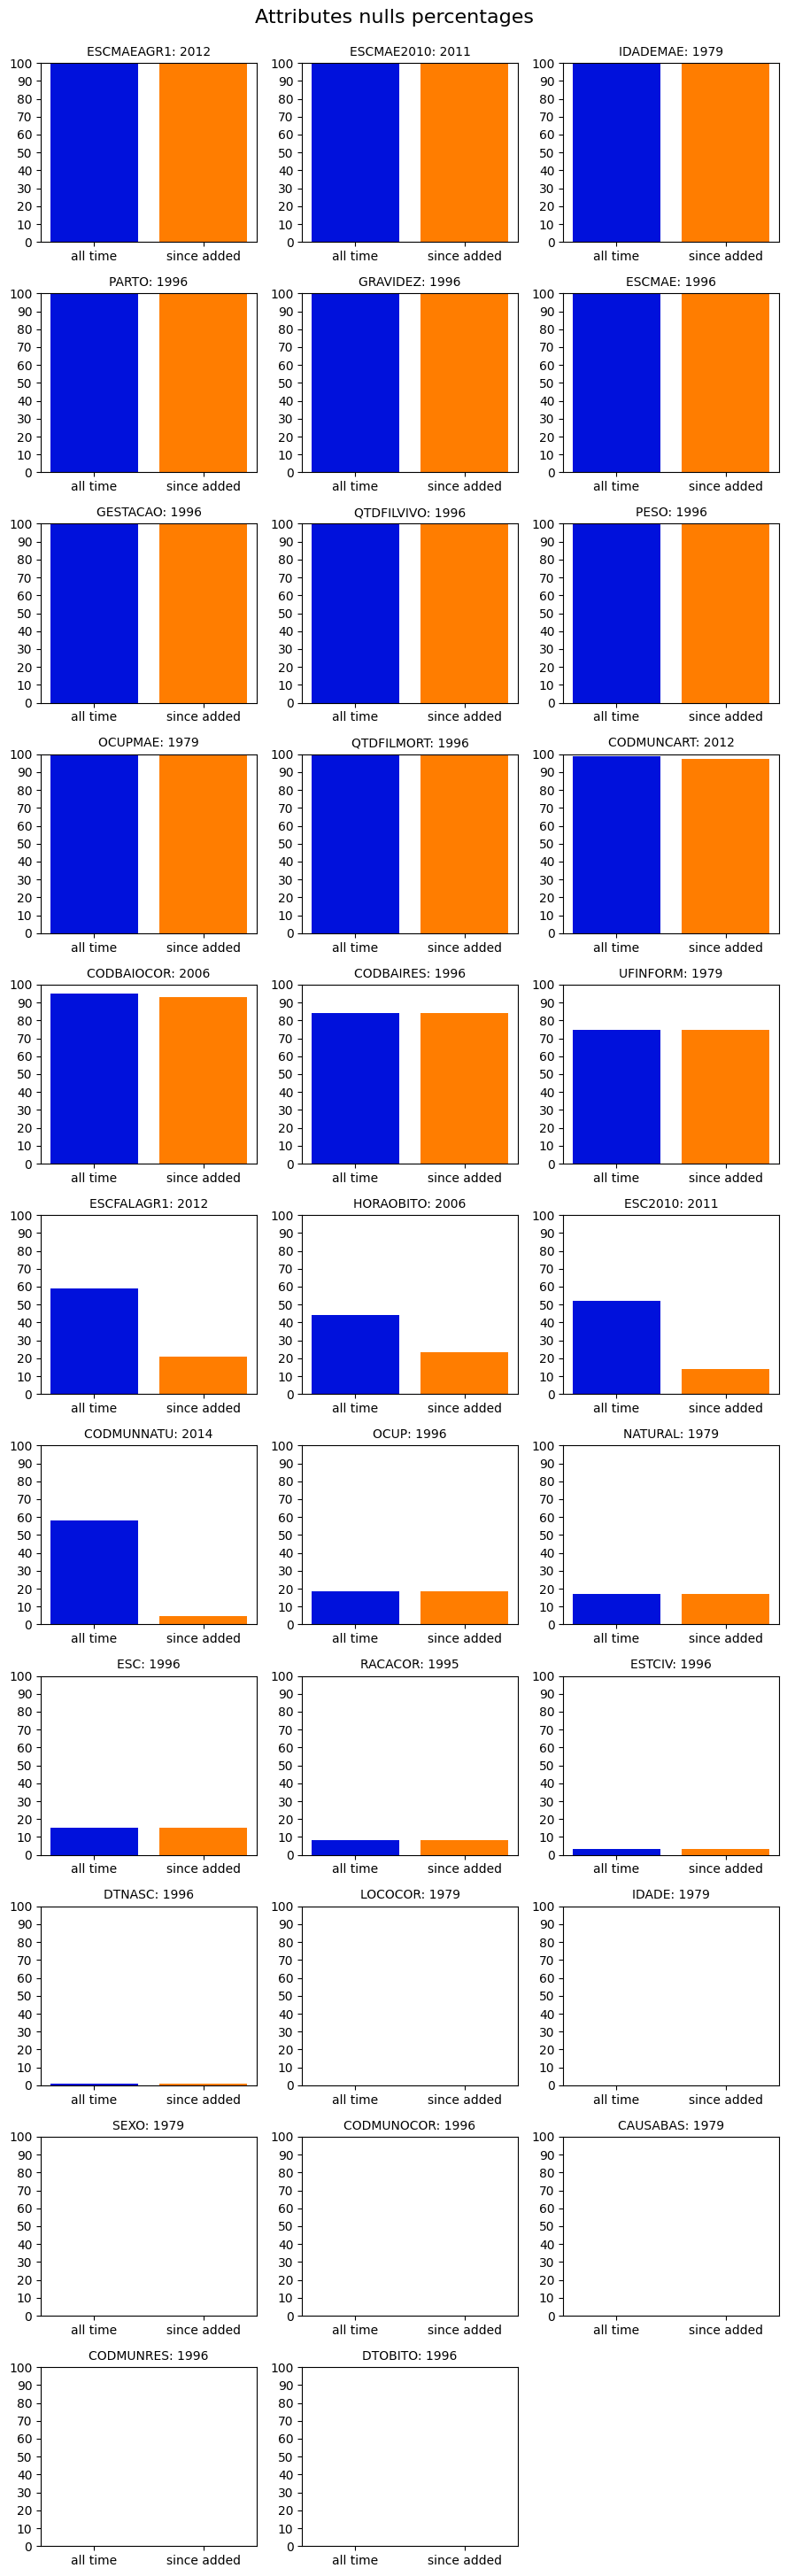

In [22]:
def plot_nulls_pct_histograms(df_to_check):

    # Calcular a soma dos percentuais nulos
    df_to_check['total_null_pct'] = df_to_check['null_pct_at'] + df_to_check['null_pct_sa']
    
    # Ordenar o DataFrame com base na soma dos percentuais nulos
    df_to_check = df_to_check.sort_values(by='total_null_pct', ascending=False).reset_index(drop=True)
    
    num_attrs = len(df_to_check)
    num_cols = 3
    num_rows = (num_attrs + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    axes = axes.flatten()

    for idx, row in df_to_check.iterrows():
        attr = row['attr']
        year_added = row['year_added']
        null_pct_at = row['null_pct_at']
        null_pct_sa = row['null_pct_sa']

        percentages = [null_pct_at, null_pct_sa]
        labels = ['all time', 'since added']

        ax = axes[idx]
        ax.bar(labels, percentages, color=[my_blue, my_orange])
        ax.set_ylim(0, 100)
        ax.set_yticks(range(0, 101, 10))
        ax.set_title(f'{attr}: {year_added}', fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Hide any empty subplots
    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.suptitle("Attributes nulls percentages", fontsize=16)
    plt.tight_layout(rect=[0, 0.1, 1, 0.9825])
    plt.show()

plot_nulls_pct_histograms(attrs_nulls_pct_df)

In [23]:
# Sampling some data from columns with more than null_pct_threshold nulls
# based on "since added" column, meaning that even data that should exist don't.
null_pct_threshold = 50
nulls_pct_threshold_columns = attrs_nulls_pct_df[attrs_nulls_pct_df['null_pct_sa'] >= null_pct_threshold]['attr']
for col in nulls_pct_threshold_columns:
    print(f"\nSample data from column '{col}':")
    print(filtered_1_df[col].sample(2, random_state=1469))


Sample data from column 'CODBAIRES':
14926    
93688    
Name: CODBAIRES, dtype: object

Sample data from column 'IDADEMAE':
14926    
93688    
Name: IDADEMAE, dtype: object

Sample data from column 'ESCMAE':
14926    
93688    
Name: ESCMAE, dtype: object

Sample data from column 'OCUPMAE':
14926    
93688    
Name: OCUPMAE, dtype: object

Sample data from column 'QTDFILVIVO':
14926    
93688    
Name: QTDFILVIVO, dtype: object

Sample data from column 'QTDFILMORT':
14926    
93688    
Name: QTDFILMORT, dtype: object

Sample data from column 'GRAVIDEZ':
14926    
93688    
Name: GRAVIDEZ, dtype: object

Sample data from column 'GESTACAO':
14926    
93688    
Name: GESTACAO, dtype: object

Sample data from column 'PARTO':
14926    
93688    
Name: PARTO, dtype: object

Sample data from column 'PESO':
14926    
93688    
Name: PESO, dtype: object

Sample data from column 'UFINFORM':
14926      
93688    32
Name: UFINFORM, dtype: object

Sample data from column 'CODBAIOCOR':
14926    


In [24]:
nulls_pct_99_columns = list(attrs_nulls_pct_df[attrs_nulls_pct_df['null_pct_sa'] >= 99]['attr'])
print(f'All columns that have more than 99% missing data: {len(nulls_pct_99_columns)}')
for col in nulls_pct_99_columns:
    print(f"{col}")

print()
nulls_pct_threshold_columns = list(attrs_nulls_pct_df[(null_pct_threshold <= attrs_nulls_pct_df['null_pct_sa'])
                                               & (attrs_nulls_pct_df['null_pct_sa'] < 99)]['attr'])
print(f'All columns that fail the threshold of {null_pct_threshold}%: {len(nulls_pct_threshold_columns)}')
for col in nulls_pct_threshold_columns:
    print(f"{col}")

# Joins both lists
nulls_pct_threshold_columns += nulls_pct_99_columns

All columns that have more than 99% missing data: 11
IDADEMAE
ESCMAE
OCUPMAE
QTDFILVIVO
QTDFILMORT
GRAVIDEZ
GESTACAO
PARTO
PESO
ESCMAE2010
ESCMAEAGR1

All columns that fail the threshold of 50%: 4
CODBAIRES
UFINFORM
CODBAIOCOR
CODMUNCART


### Filtering too many nulls based on year of addition

There are many columns that have more than the threshold of nulls in the database, even on data that should exist based on the date the attribute started being used, so they are being removed. The threshold is arbitrary, but 'null_pct_threshold' is too much.

In [25]:
print('Nº of columns before filtering the nulls:', len(filtered_1_df.columns))

filtered_2_df = filtered_1_df.drop(columns=list(nulls_pct_threshold_columns))
print('Nº of columns after filtering the nulls:', len(filtered_2_df.columns))

filtered_2_df_columns = list(filtered_2_df.columns)
# Filter df_attrs_info to only include columns that are in filtered_2_df
filtered_2_df_attrs_info = df_attrs_info[df_attrs_info['name'].isin(filtered_2_df_columns)]

Nº of columns before filtering the nulls: 34
Nº of columns after filtering the nulls: 19


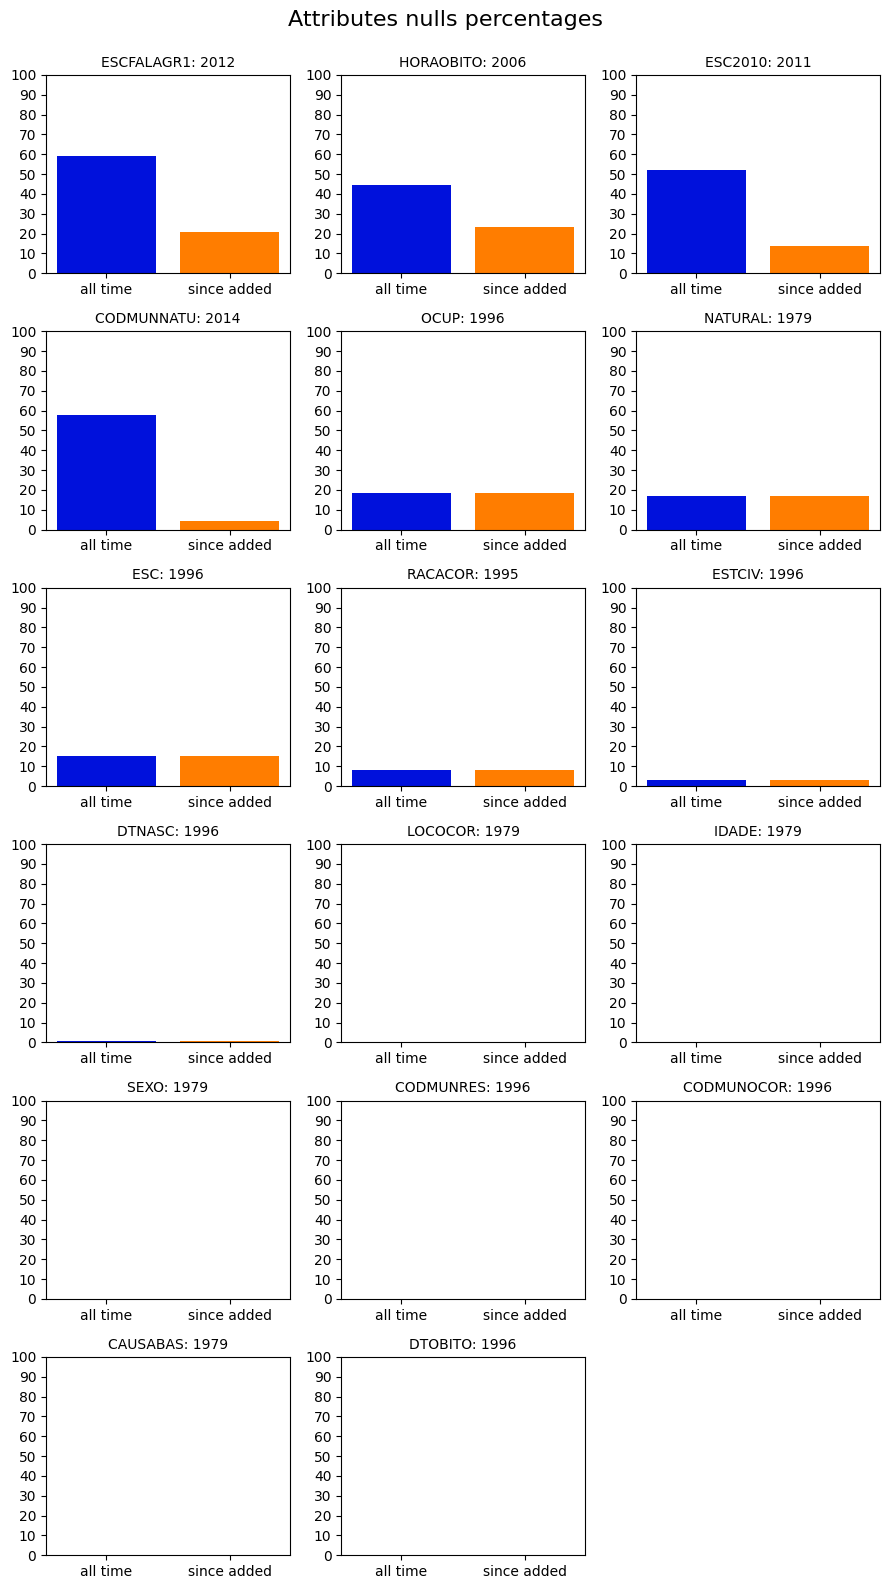

In [26]:
# Calculate the null percentages and create the summary dataframe
attrs_nulls_pct_3_df = calculate_attr_null_percentages(filtered_2_df, filtered_2_df_attrs_info)

plot_nulls_pct_histograms(attrs_nulls_pct_3_df)

### Filtering too many nulls based on the year of data collection

CODMUNNATU and HORAOBITO
have too many nulls for all time , since they were added in 2014 and 2006, respectively:

In [27]:
print('Nº of nulls for CODMUNNATU:', attrs_nulls_pct_3_df['null_pct_at'][attrs_nulls_pct_3_df['attr'] == 'CODMUNNATU'].values[0])
print('Nº of nulls for HORAOBITO:', attrs_nulls_pct_3_df['null_pct_at'][attrs_nulls_pct_3_df['attr'] == 'HORAOBITO'].values[0])

Nº of nulls for CODMUNNATU: 58.000716482073024
Nº of nulls for HORAOBITO: 44.40024479804162


In [28]:
if 'CODMUNNATU' and 'HORAOBITO' in filtered_2_df.columns:
    filtered_2_df = filtered_2_df.drop(columns=['CODMUNNATU', 'HORAOBITO'], inplace=False)
filtered_2_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267976 entries, 0 to 268027
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ESTADO      267976 non-null  object        
 1   ANO         267976 non-null  int64         
 2   DTOBITO     267976 non-null  datetime64[ns]
 3   NATURAL     267976 non-null  object        
 4   DTNASC      267976 non-null  object        
 5   IDADE       267976 non-null  object        
 6   SEXO        267976 non-null  object        
 7   RACACOR     267976 non-null  object        
 8   ESTCIV      267976 non-null  object        
 9   ESC         267976 non-null  object        
 10  OCUP        267976 non-null  object        
 11  CODMUNRES   267976 non-null  int64         
 12  LOCOCOR     267976 non-null  object        
 13  CODMUNOCOR  267976 non-null  int64         
 14  CAUSABAS    267976 non-null  object        
 15  ESC2010     267976 non-null  object        
 16  ESCFALA

#### Handling "SEXO" values

In [29]:
def handle_col_null_values(df, current_col, valid_values, nan_value, remove_nans=False):
    df_value_counts = df[current_col].value_counts()
    print(df_value_counts, '\n')

    df[current_col] = df[current_col].apply(lambda x: x if x in valid_values else nan_value)

    n_of_removed = 0
    # Filter the dataframe to keep only rows with 'masculino' or 'feminino'
    if remove_nans:
        n_of_removed += len(df[df[current_col] == nan_value])
        df = df[df[current_col].isin(valid_values)]

    df_value_counts2 = df[current_col].value_counts()
    print(df_value_counts2, '\n')

    print(f"Nº of 'Ignorado' values removed from {current_col}: {n_of_removed}")
    return df

In [30]:
filtered_3_df = filtered_2_df.copy()

print(filtered_3_df['SEXO'].isna().value_counts())
print(conversion_dict['SEXO'])
filtered_3_df = handle_col_null_values(filtered_3_df, "SEXO", ['1', '2'], '9', False)

SEXO
False    267976
Name: count, dtype: int64
{'1': 'masculino', '2': 'feminino', '0': 'Ignorado', '9': 'Ignorado'}
SEXO
1    211249
2     56672
0        50
          4
9         1
Name: count, dtype: int64 

SEXO
1    211249
2     56672
9        55
Name: count, dtype: int64 

Nº of 'Ignorado' values removed from SEXO: 0


In [31]:
print(filtered_3_df['RACACOR'].isna().value_counts())
print(filtered_3_df['RACACOR'][filtered_3_df['RACACOR'] == ''].value_counts())
print(conversion_dict['RACACOR'])
filtered_3_df = handle_col_null_values(filtered_3_df, "RACACOR", ['1', '2', '3', '4', '5'], '9', False)

RACACOR
False    267976
Name: count, dtype: int64
RACACOR
    21535
Name: count, dtype: int64
{'1': 'Branca', '2': 'Preta', '3': 'Amarela', '4': 'Parda', '5': 'Indígena', '9': 'Ignorado'}
RACACOR
1    132631
4     96471
      21535
2     13576
5      2403
3      1359
9         1
Name: count, dtype: int64 

RACACOR
1    132631
4     96471
9     21536
2     13576
5      2403
3      1359
Name: count, dtype: int64 

Nº of 'Ignorado' values removed from RACACOR: 0


In [32]:
print(filtered_3_df['ESTCIV'].isna().value_counts())
print(filtered_3_df['ESTCIV'][filtered_3_df['ESTCIV'] == ''].value_counts())
print(conversion_dict['ESTCIV'])
filtered_3_df = handle_col_null_values(filtered_3_df, "ESTCIV", ['1', '2', '3', '4', '5'], '9', False)

ESTCIV
False    267976
Name: count, dtype: int64
ESTCIV
    8367
Name: count, dtype: int64
{'1': 'Solteiro', '2': 'Casado', '3': 'Viúvo', '4': 'Separado judicialmente', '5': 'União consensual', '9': 'Ignorado'}
ESTCIV
1    133106
2     78322
4     16364
9     11713
3     10523
5      9581
       8367
Name: count, dtype: int64 

ESTCIV
1    133106
2     78322
9     20080
4     16364
3     10523
5      9581
Name: count, dtype: int64 

Nº of 'Ignorado' values removed from ESTCIV: 0


### Dictionary conversion standardization

We need to standardize some attributes that hold similar values, like "ESC", "ESC2010" and "ESCFALAGR1"

![image.png](../utils/attrs-utils/attrs-info/imgs/ESC%20table%20conversion.png)

"1 a 8 anos" and "9 a 11 anos" should be 6 or 7, but there's actually data that corresponds to a nominal value of 8, so "9 a 11 anos" will be considered being 8 for proximity, and its value will be the same as "8 a 11 anos" because of the superposing range

In [33]:
# Attempt to convert the categorical data in scholarity (escolaridade) 
# attributes into a unified numerical data, because they represent 
# years of study, so technically there is a linear numerical correlation

# Transforming the data into numerical, a range of years is defined by the mean
ESC_MAP = {
    "0": 0,   # Ignorado
    "1": 0,   # Nenhuma
    "2": 2,   # 1 a 3 anos
    "3": 5.5, # 4 a 7 anos
    "4": 9.5, # 8 a 11 anos
    "5": 12,  # 12 anos e mais
    "8": 9.5, # 9 a 11 anos
    "9": 0    # Ignorado
}
ESC2010_MAP = {
    "0": 0,   # Ignorado
    "1": 2,   # Fundamental I (1ª a 4ª série)
    "2": 5.5,   # Fundamental II (5ª a 8ª série)
    "3": 9.5, # Médio (antigo 2º Grau)
    "4": 12,  # Superior incompleto
    "5": 14,  # Superior completo
    "9": 0    # Ignorado
}
ESCFALAGR1_MAP = {
    "00": 0,   # Sem escolaridade
    "01": 2,   # Fundamental I Incompleto
    "02": 4,   # Fundamental I Completo
    "03": 5.5, # Fundamental II Incompleto
    "04": 8,   # Fundamental II Completo
    "05": 9.5, # Ensino Médio Incompleto
    "06": 11,  # Ensino Médio Completo
    "07": 12,  # Superior Incompleto
    "08": 14,  # Superior Completo
    "09": 0,   # Ignorado
    "10": 2,   # Fundamental I Incompleto ou Inespecífico
    "11": 5.5, # Fundamental II Incompleto ou Inespecífico
    "12": 9.5  # Ensino Médio Incompleto ou Inespecífico
}

conversion_dict['ESC'] = ESC_MAP
conversion_dict['ESC2010'] = ESC2010_MAP
conversion_dict['ESCFALAGR1'] = ESCFALAGR1_MAP
conversion_dict['ESCMAE'] = ESC_MAP
conversion_dict['ESCMAE2010'] = ESC2010_MAP
conversion_dict['ESCMAEAGR1'] = ESCFALAGR1_MAP

In [34]:
# Atributos de data
birth_date_ats = ['DTNASC', 'DATANASC']

# Check if the columns exist and convert them to datetime
filtered_3_df = clean_dates_data(df=filtered_3_df, date_columns=birth_date_ats, remove_nans=False)

def process_age(df, age_col, birth_col, death_col, remove_nans=True):
    def calculate_age(row):
        # Gets the age as a string
        age_str = str(row[age_col])
        # Gets the first subgroup
        first_digit = int(age_str[0]) if age_str else None
        # Gets the second subgroup
        value = int(age_str[1:]) if age_str and len(age_str) > 1 else None
        
        # Since it's suicide data, we only care about year units (4 or 5)
        if first_digit in [4]:
            return value
        # If it's 5, means if higher than 100 years, so we sum the value
        elif first_digit in [5]:
            return 100 + value
        # There might be valid ages that can be extracted with date subtraction
        else:
            birth_date = row[birth_col]
            death_date = row[death_col]
            # If both are not null
            if pd.notna(birth_date) and pd.notna(death_date):
                # Get the age difference in years between death and birth dates
                age_diff = (death_date - birth_date).days // 365
                # If it's more or equal than 5
                if age_diff >= 5:
                    return age_diff
        return np.nan

    # Apply the function to each row of the dataframe
    df[age_col] = df.apply(calculate_age, axis=1)

    invalid_rows = df[df[age_col].isna()]
    if remove_nans:
        df = df.dropna(subset=[age_col])
        print(f'Nº of filtered {age_col} invalid rows: {len(invalid_rows)}')
        print(f'Example of filtered {age_col} invalid rows:')
        display(invalid_rows.head())
    else:
        print(f'Nº of unfiltered {age_col} invalid rows: {len(invalid_rows)}\n')

    return df

Column: DTNASC
Unstandardized date example:
0     5081963
1    21091920
Name: DTNASC, dtype: object

Standardized date example:
0   1963-08-05
1   1920-09-21
Name: DTNASC, dtype: datetime64[ns]

Percentage of missing values in dates:
   attribute    null_%
0    DTNASC  0.791862
Number of unfiltered DTNASC invalid rows: 2122



In [35]:
filtered_3_df = process_age(df=filtered_3_df, age_col='IDADE', birth_col='DTNASC', death_col='DTOBITO')

print(filtered_3_df['IDADE'].value_counts())

Nº of filtered IDADE invalid rows: 759
Example of filtered IDADE invalid rows:


,ESTADO,ANO,DTOBITO,NATURAL,DTNASC,IDADE,SEXO,RACACOR,ESTCIV,ESC,OCUP,CODMUNRES,LOCOCOR,CODMUNOCOR,CAUSABAS,ESC2010,ESCFALAGR1
226,PR,1996,1996-11-25,,NaT,NaN,1,9,9,,,4119509,,4119509,X699,,NaN
528,PR,1996,1996-07-25,800,NaT,NaN,1,9,9,,,4121000,5,4121000,X849,,NaN
638,RS,1996,1996-01-21,,NaT,NaN,2,9,9,,,4315909,3,4315909,X700,,NaN
725,RS,1996,1996-03-05,843,NaT,NaN,2,9,2,,800,4319752,5,4319752,X719,,NaN
759,RS,1996,1996-04-28,843,NaT,NaN,1,9,3,,700,4315701,3,4315701,X700,,NaN


IDADE
22.0     6103
23.0     6062
30.0     6012
25.0     5995
24.0     5944
         ... 
102.0       3
104.0       2
5.0         2
4.0         1
2.0         1
Name: count, Length: 105, dtype: int64


#### Showing a few rows to check if the conversion was successful

In [36]:
# Display the first few rows of the converted dataframe
display(filtered_3_df[-8:])

for col, mapping in conversion_dict.items():
    if col in filtered_3_df.columns:
        filtered_3_df[col] = filtered_3_df[col].map(mapping)

# Display the first few rows of the converted dataframe
display(filtered_3_df[-8:])

,ESTADO,ANO,DTOBITO,NATURAL,DTNASC,IDADE,SEXO,RACACOR,ESTCIV,ESC,OCUP,CODMUNRES,LOCOCOR,CODMUNOCOR,CAUSABAS,ESC2010,ESCFALAGR1
268020,MT,2022,2022-12-17,851,1996-05-21,26.0,1,4,1,4,322205,510642,3,510642,X700,2,04
268021,MT,2022,2022-07-28,851,1992-06-11,30.0,1,1,1,9,998999,510250,1,510675,X649,,
268022,MT,2022,2022-11-13,851,1989-11-25,32.0,2,4,5,3,999992,510267,3,510267,X740,2,03
268023,MT,2022,2022-09-17,851,1982-08-28,40.0,1,4,5,2,622005,510395,3,510395,X730,1,01
268024,MT,2022,2022-08-21,815,1998-09-11,23.0,1,4,1,4,715210,510340,5,510340,X708,2,04
268025,MT,2022,2022-10-14,851,1993-06-23,29.0,1,1,1,4,914405,510760,3,510760,X700,3,06
268026,MT,2022,2022-10-09,851,1981-06-12,41.0,1,4,1,5,354705,510760,3,510760,X700,4,07
268027,MT,2022,2022-09-17,841,1971-05-11,51.0,1,4,2,4,512105,510724,3,510724,X700,3,12


,ESTADO,ANO,DTOBITO,NATURAL,DTNASC,IDADE,SEXO,RACACOR,ESTCIV,ESC,OCUP,CODMUNRES,LOCOCOR,CODMUNOCOR,CAUSABAS,ESC2010,ESCFALAGR1
268020,MT,2022,2022-12-17,851,1996-05-21,26.0,masculino,Parda,Solteiro,9.5,322205,510642,domicílio,510642,X700,5.5,8.0
268021,MT,2022,2022-07-28,851,1992-06-11,30.0,masculino,Branca,Solteiro,0.0,998999,510250,hospital,510675,X649,NaN,NaN
268022,MT,2022,2022-11-13,851,1989-11-25,32.0,feminino,Parda,União consensual,5.5,999992,510267,domicílio,510267,X740,5.5,5.5
268023,MT,2022,2022-09-17,851,1982-08-28,40.0,masculino,Parda,União consensual,2.0,622005,510395,domicílio,510395,X730,2.0,2.0
268024,MT,2022,2022-08-21,815,1998-09-11,23.0,masculino,Parda,Solteiro,9.5,715210,510340,outros,510340,X708,5.5,8.0
268025,MT,2022,2022-10-14,851,1993-06-23,29.0,masculino,Branca,Solteiro,9.5,914405,510760,domicílio,510760,X700,9.5,11.0
268026,MT,2022,2022-10-09,851,1981-06-12,41.0,masculino,Parda,Solteiro,12.0,354705,510760,domicílio,510760,X700,12.0,12.0
268027,MT,2022,2022-09-17,841,1971-05-11,51.0,masculino,Parda,Casado,9.5,512105,510724,domicílio,510724,X700,9.5,9.5


In [37]:
# Function to check whether there are values that don't conform with the dictionaries, 
# be it a placeholder value that doesn't exist or a conversion that doesn't exist
def check_column_value_validity(df, col_name, conversion_dict):
    converted_df = df.copy()
    c_keys = list(conversion_dict[col_name].keys())

    converted_values = []
    invalid_values = []

    for val in df[col_name]:
        if val == 0 or val == '0':
            converted_values.append(0)
        elif val in c_keys:
            converted_values.append(conversion_dict[col_name][val])
        else:
            converted_values.append(0)
            invalid_values.append(val)

    converted_df[col_name] = converted_values

    return converted_df[col_name], invalid_values

In [38]:
# From where the CBO list was downloaded from:
# http://www.mtecbo.gov.br/cbosite/pages/downloads.jsf
CBO2002 = pd.read_csv(root_dir + "/utils/attrs-utils/cbo_list/CBO.csv", sep=',')
CBO2002_dict = CBO2002.sort_values(by="CODIGO").set_index("CODIGO").to_dict()
CBO2002_dict['OCUP'] = CBO2002_dict.pop('OCUPACAO')

# CBO94 conversion table:
# http://www.joviccontabilidade.com.br/assets/tabelacbo-completa.pdf
# CBO94 Database:
# http://www.mtecbo.gov.br/cbosite/pages/tabua/BaseDados_CBO94.jsf

# I'm not gonna do this for now
# CBO94_dict = {
#     "OCUP94": {
#         # This has to be created because current CBO 
#         # works only from 2002 onwards
#         "61200": "Agricultor familiar generalizado"
#     }

print(CBO2002_dict)

def check_ocup_codes(code):
    try:
        ocup_float = float(code)
        # Invalid number case
        if ocup_float <= 0:
            return 0
        # Else return the code
        return int(np.floor(ocup_float))
    # If it couldn't be converted to float, it's not numeric
    except ValueError:
        return 0

# Because apply breaks df on rerun
filtered_4_df = filtered_3_df.copy()
filtered_4_df['OCUP'] = filtered_4_df['OCUP'].apply(lambda x: check_ocup_codes(x))

print('\n', filtered_4_df['OCUP'])

{'OCUP': {10105: 'OFICIAL GENERAL DA AERONAUTICA', 10110: 'OFICIAL GENERAL DO EXERCITO', 10115: 'OFICIAL GENERAL DA MARINHA', 10205: 'OFICIAL DA AERONAUTICA', 10210: 'OFICIAL DO EXERCITO', 10215: 'OFICIAL DA MARINHA', 10305: 'PRACA DA AERONAUTICA', 10310: 'PRACA DO EXERCITO', 10315: 'PRACA DA MARINHA', 20105: 'CORONEL DA POLICIA MILITAR', 20110: 'TENENTE-CORONEL DA POLICIA MILITAR', 20115: 'MAJOR DA POLICIA MILITAR', 20205: 'CAPITAO DA POLICIA MILITAR', 20305: 'PRIMEIRO TENENTE DE POLICIA MILITAR', 20310: 'SEGUNDO TENENTE DE POLICIA MILITAR', 21105: 'SUBTENENTE DA POLICIA MILITAR', 21110: 'SARGENTO DA POLICIA MILITAR', 21205: 'CABO DA POLICIA MILITAR', 21210: 'SOLDADO DA POLICIA MILITAR', 30105: 'CORONEL BOMBEIRO MILITAR', 30110: 'MAJOR BOMBEIRO MILITAR', 30115: 'TENENTE-CORONEL BOMBEIRO MILITAR', 30205: 'CAPITAO BOMBEIRO MILITAR', 30305: 'TENENTE DO CORPO DE BOMBEIROS MILITAR', 31105: 'SUBTENENTE BOMBEIRO MILITAR', 31110: 'SARGENTO BOMBEIRO MILITAR', 31205: 'CABO BOMBEIRO MILITAR', 31

In [39]:
converted_ocup_df, invalid_values = check_column_value_validity(filtered_4_df, 'OCUP', CBO2002_dict)
print('\nInvalid values (not counting 0):', len(invalid_values))
print('\nNº of 0 values:', converted_ocup_df[converted_ocup_df == 0].value_counts())

filtered_4_df['OCUP'] = converted_ocup_df

print('\n', filtered_4_df['OCUP'].value_counts())


Invalid values (not counting 0): 66724

Nº of 0 values: OCUP
0    116209
Name: count, dtype: int64

 OCUP
0                                                    116209
ESTUDANTE                                             13366
APOSENTADO/PENSIONISTA                                13187
DONA DE CASA                                          10646
TRABALHADOR AGROPECUARIO EM GERAL                     10350
                                                      ...  
OPERADOR DE CABINE DE LAMINACAO (FIO-MAQUINA)             1
TECNICO EM MADEIRA                                        1
MECANICO DE MANUTENCAO DE REDUTORES                       1
TRABALHADOR DA FABRICACAO DE MUNICAO E EXPLOSIVOS         1
TECNICO DE VENDAS                                         1
Name: count, Length: 1608, dtype: int64


In [40]:
# http://blog.mds.gov.br/redesuas/lista-de-municipios-brasileiros/
# site do governo nunca tem assinatura digital
url_codmunres = "http://blog.mds.gov.br/redesuas/wp-content/uploads/2018/06/Lista_Munic%C3%ADpios_com_IBGE_Brasil_Versao_CSV.csv"

local_path = root_dir + "/utils/attrs-utils/codmunres/Lista_Municipios_com_IBGE_Brasil_Versao_CSV.csv"
# Ensure the local directory exists
os.makedirs(os.path.dirname(local_path), exist_ok=True)

def read_csv_with_version(url_or_path):
    pd_version = pd.__version__
    if pd_version >= '1.3':
        return pd.read_csv(url_or_path, on_bad_lines='skip', sep=";", encoding="latin-1", usecols=["IBGE", "Município"])
    else:
        return pd.read_csv(url_or_path, error_bad_lines=False, sep=";", encoding="latin-1", usecols=["IBGE", "Município"])

if not os.path.isfile(local_path):
    try:
        mun_codes = read_csv_with_version(url_codmunres)
        mun_codes.to_csv(local_path, sep=";", encoding="latin-1", index=False)
    except Exception as e:
        print(f"Error downloading the file: {e}")
        raise
else:
    mun_codes = read_csv_with_version(local_path)
mun_codes = mun_codes.set_index("IBGE").to_dict()["Município"]

import pkg_resources
# Package checking list
packages_to_check = [
    {
     'name': 'xlrd',
     'version':'2.0.1'
     },
    ]
# check if necessary packages are installed, and install if not
for package in packages_to_check:
    print(package)
    try:
        pkg_resources.get_distribution(package['name'])
        print(f"{package['name']} is installed.")
    except pkg_resources.DistributionNotFound:
        print(f"{package['name']} is not installed. Installing:")
        %pip install {package['name']}=={package['version']}

local_path_new = root_dir + "/utils/attrs-utils/codmunres/RELATORIO_DTB_BRASIL_MUNICIPIO.xls"
mun_codes_new = pd.read_excel(local_path_new)

# Select the columns from the 8th row onwards
mun_codes_new = mun_codes_new.iloc[7:]
rightmost_columns = mun_codes_new.iloc[1:, -2:]
mun_codes_new = pd.Series(rightmost_columns.iloc[:, 1].values, index=rightmost_columns.iloc[:, 0]).to_dict()

print([key_value for i, key_value in enumerate(mun_codes.items()) if i < 4])
print([key_value for i, key_value in enumerate(mun_codes_new.items()) if i < 4])

{'name': 'xlrd', 'version': '2.0.1'}
xlrd is installed.
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'
[(110001, 'Alta Floresta D´oeste'), (110002, 'Ariquemes'), (110003, 'Cabixi'), (110004, 'Cacoal')]
[('1100403', 'Alto Paraíso'), ('1100346', "Alvorada D'Oeste"), ('1100023', 'Ariquemes'), ('1100452', 'Buritis')]


In [41]:
def generate_municipality_dict(newer_dict, old_dict=None):
    combined_dict = newer_dict.copy()
    if old_dict:
        print('Combining the dictionaries:')
        combined_dict.update(old_dict)
    for key, value in newer_dict.items():
        truncated_key = key[:-1]
        if truncated_key not in combined_dict:
            combined_dict[truncated_key] = value
    print('Dictionaries combined.')
    return combined_dict

def convert_municipality_codes(df, mun_codes_columns, mun_codes_dict):
    mun_df = df.copy()
    if mun_codes_columns and mun_codes_dict:    
        for mun_col in mun_codes_columns:
            # Convert the column values using the provided dictionary
            mun_df[mun_col] = df[mun_col].astype(str).replace(mun_codes_dict)
            print(f"Municipality codes for {mun_col} replaced using mun_codes_dict.")
        return mun_df
    else:
        print('No columns were altered because at least one dict and one column must be specified.')
        return df

def check_invalid_conversions(df, col_name):
    numeric_col = pd.to_numeric(df[col_name], errors='coerce')
    invalid_indexes = numeric_col[~numeric_col.isna()].index
    invalid_codes = df.loc[invalid_indexes, col_name]

    print(f'Nº of invalid codes in {col_name}:', len(invalid_codes))
    print(f'Nº of unique invalid codes:', len(invalid_codes.unique()))
    print(f'Example of invalid codes: {list(invalid_codes[0:5])}\n')

    return invalid_indexes, invalid_codes

In [42]:
# To prevent rerun errors
filtered_5_df = filtered_4_df.copy()

mun_codes_dict = generate_municipality_dict(mun_codes_new, mun_codes)
# municipality_cols_to_check = ['CODMUNRES', 'CODMUNOCOR']
municipality_cols_to_check = ['CODMUNOCOR', 'CODMUNRES']

# Replacing valid codes for municipality columns:
filtered_5_df = convert_municipality_codes(filtered_5_df, municipality_cols_to_check, mun_codes_dict)

Combining the dictionaries:
Dictionaries combined.
Municipality codes for CODMUNOCOR replaced using mun_codes_dict.
Municipality codes for CODMUNRES replaced using mun_codes_dict.


In [43]:
# Checking valid codes for municipality columns:
for col in municipality_cols_to_check:
    print('-------------------------------------------------')
    invalid_mun_idxes, invalid_mun_codes_df = check_invalid_conversions(filtered_5_df, col)
    # Removing the invalid codes from the dataframe:
    if len(invalid_mun_idxes):
        filtered_5_df = filtered_5_df.drop(invalid_mun_idxes, axis=0, inplace=False).reset_index(drop=True)
    print(filtered_5_df[col].value_counts())

print(f'\nTotal removal of data: {filtered_4_df.shape[0] - filtered_5_df.shape[0]}')

-------------------------------------------------
Nº of invalid codes in CODMUNOCOR: 468
Nº of unique invalid codes: 41
Example of invalid codes: ['3345204', '3345121', '3345246', '3345022', '3345022']

CODMUNOCOR
São Paulo                   13095
Rio de Janeiro               4929
Belo Horizonte               3940
Fortaleza                    3872
Brasília                     3754
                            ...  
Leme do Prado                   1
Campinaçu                       1
Paiva                           1
Monte Santo do Tocantins        1
Vila Flor                       1
Name: count, Length: 5257, dtype: int64
-------------------------------------------------
Nº of invalid codes in CODMUNRES: 513
Nº of unique invalid codes: 49
Example of invalid codes: ['4300000', '3200000', '3200000', '3200000', '3200000']

CODMUNRES
São Paulo                  11445
Rio de Janeiro              4739
Brasília                    3486
Fortaleza                   3418
Belo Horizonte              

In [44]:
print(filtered_5_df['NATURAL'].value_counts())
print(filtered_5_df['NATURAL'][filtered_5_df['NATURAL'] == ''].value_counts())

# Replace empty strings and 'NaN' with np.nan
filtered_5_df['NATURAL'].replace(['', None], np.nan, inplace=True)
# Convert the column to numeric, coercing errors to NaN
filtered_5_df['NATURAL'] = pd.to_numeric(filtered_5_df['NATURAL'], errors='coerce')

print(filtered_5_df['NATURAL'].info())

NATURAL
       44481
835    36085
843    27151
831    27132
841    16705
       ...  
160        1
183        1
19         1
43         1
104        1
Name: count, Length: 144, dtype: int64
NATURAL
    44481
Name: count, dtype: int64
<class 'pandas.core.series.Series'>
RangeIndex: 266236 entries, 0 to 266235
Series name: NATURAL
Non-Null Count   Dtype  
--------------   -----  
221755 non-null  float64
dtypes: float64(1)
memory usage: 2.0 MB
None


In [45]:
filtered_6_df = filtered_5_df.copy()

filtered_6_df['LOCOCOR'].unique()
n_of_ignorados = filtered_6_df['LOCOCOR'][filtered_6_df['LOCOCOR'] == 'ignorado'].value_counts().sum()
n_of_nulls = filtered_6_df['LOCOCOR'].isna()

print(f'Nº of "ignorado" values in LOCOCOR: {n_of_ignorados}')
print(f'Nº of nulls values in LOCOCOR: {n_of_nulls.sum()}')

filtered_6_df['LOCOCOR'] = filtered_6_df['LOCOCOR'].fillna('ignorado')

n_of_ignorados = filtered_6_df['LOCOCOR'][filtered_6_df['LOCOCOR'] == 'ignorado'].value_counts().sum()
n_of_nulls = filtered_6_df['LOCOCOR'].isna()

print(f'Nº of "ignorado" values in LOCOCOR after conversion: {n_of_ignorados}')
print(f'Nº of nulls values in LOCOCOR after conversion: {n_of_nulls.sum()}')

Nº of "ignorado" values in LOCOCOR: 2126
Nº of nulls values in LOCOCOR: 376
Nº of "ignorado" values in LOCOCOR after conversion: 2502
Nº of nulls values in LOCOCOR after conversion: 0


In [46]:
dataframe_shape = dataframe.shape
dataframe_size = dataframe.index.size
print(f'dataframe       : {dataframe_shape}')

valid_dtobito_df_shape = valid_dtobito_df.shape
valid_dtobito_df_size = valid_dtobito_df.index.size
print(f'valid_dtobito_df: {valid_dtobito_df_shape}')

filtered_1_df_shape = filtered_1_df.shape
filtered_1_df_size = filtered_1_df.index.size
print(f'filtered_1_df   : {filtered_1_df_shape}')

filtered_2_df_shape = filtered_2_df.shape
filtered_2_df_size = filtered_2_df.index.size
print(f'filtered_2_df   : {filtered_2_df_shape}')

filtered_3_df_shape = filtered_3_df.shape
filtered_3_df_size = filtered_3_df.index.size
print(f'filtered_3_df   : {filtered_3_df_shape}')

filtered_4_df_shape = filtered_4_df.shape
filtered_4_df_size = filtered_4_df.index.size
print(f'filtered_4_df   : {filtered_4_df_shape}')

filtered_5_df_shape = filtered_5_df.shape
filtered_5_df_size = filtered_5_df.index.size
print(f'filtered_5_df   : {filtered_5_df_shape}')

filtered_6_df_shape = filtered_6_df.shape
filtered_6_df_size = filtered_6_df.index.size
print(f'filtered_6_df   : {filtered_6_df_shape}')

dataframe       : (268028, 103)
valid_dtobito_df: (267976, 103)
filtered_1_df   : (267976, 34)
filtered_2_df   : (267976, 17)
filtered_3_df   : (267217, 17)
filtered_4_df   : (267217, 17)
filtered_5_df   : (266236, 17)
filtered_6_df   : (266236, 17)


In [47]:
print(f'Original dataframe: {dataframe_size} entries.')
print(f'valid_dtobito_df dataframe: {valid_dtobito_df_size} entries.')
print(f'filtered_2_df dataframe: {filtered_2_df_size} entries.')

print(f'\nDifference of Nº of entries after 1st filter: {dataframe_size - valid_dtobito_df_size}')
pct_1 = (((dataframe_size - valid_dtobito_df_size)*100)/valid_dtobito_df_size)
print(f'Data loss percentage: {pct_1:.4f}%')

print(f'\nDifference of Nº of entries after 2nd filter: {valid_dtobito_df_size - filtered_2_df_size}')
pct_2 = (((valid_dtobito_df_size - filtered_2_df_size)*100)/filtered_2_df_size)
print(f'Data loss percentage: {pct_2:.4f}%')

print(f'\nDifference of Nº of entries after 3rd filter: {filtered_3_df_size - filtered_4_df_size}')
pct_3 = (((filtered_3_df_size - filtered_4_df_size)*100)/filtered_4_df_size)
print(f'Data loss percentage: {pct_3:.4f}%')

print(f'\nDifference of Nº of entries after 4th filter: {filtered_5_df_size - filtered_6_df_size}')
pct_4 = (((filtered_5_df_size - filtered_6_df_size)*100)/filtered_6_df_size)
print(f'Data loss percentage: {pct_3:.4f}%')

print(f'\nTotal data loss percentage: {pct_1 + pct_2 + pct_3 + pct_4:.4f}%')

Original dataframe: 268028 entries.
valid_dtobito_df dataframe: 267976 entries.
filtered_2_df dataframe: 267976 entries.

Difference of Nº of entries after 1st filter: 52
Data loss percentage: 0.0194%

Difference of Nº of entries after 2nd filter: 0
Data loss percentage: 0.0000%

Difference of Nº of entries after 3rd filter: 0
Data loss percentage: 0.0000%

Difference of Nº of entries after 4th filter: 0
Data loss percentage: 0.0000%

Total data loss percentage: 0.0194%


### Percentage of null values

In [48]:
filtered_6_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266236 entries, 0 to 266235
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ESTADO      266236 non-null  object        
 1   ANO         266236 non-null  int64         
 2   DTOBITO     266236 non-null  datetime64[ns]
 3   NATURAL     221755 non-null  float64       
 4   DTNASC      265002 non-null  datetime64[ns]
 5   IDADE       266236 non-null  float64       
 6   SEXO        266236 non-null  object        
 7   RACACOR     266236 non-null  object        
 8   ESTCIV      266236 non-null  object        
 9   ESC         225889 non-null  float64       
 10  OCUP        266236 non-null  object        
 11  CODMUNRES   266236 non-null  object        
 12  LOCOCOR     266236 non-null  object        
 13  CODMUNOCOR  266236 non-null  object        
 14  CAUSABAS    266236 non-null  object        
 15  ESC2010     127700 non-null  float64       
 16  ES

In [49]:
filtered_6_df.value_counts()

ESTADO  ANO   DTOBITO     NATURAL  DTNASC      IDADE  SEXO       RACACOR  ESTCIV            ESC   OCUP                            CODMUNRES                   LOCOCOR    CODMUNOCOR      CAUSABAS  ESC2010  ESCFALAGR1
MT      2014  2014-03-21  851.0    1987-04-04  26.0   masculino  Parda    Solteiro          5.5   PEDREIRO                        Cuiabá                      domicílio  Cuiabá          X700      5.5      5.5           2
AC      2014  2014-01-02  812.0    1977-07-02  36.0   masculino  Preta    Casado            5.5   ATLETA PROFISSIONAL DE FUTEBOL  Rio Branco                  domicílio  Rio Branco      X700      5.5      5.5           1
RS      2017  2017-05-26  843.0    1963-04-06  54.0   masculino  Branca   Casado            0.0   0                               Santo Cristo                domicílio  Santo Cristo    X700      0.0      0.0           1
              2017-05-29  843.0    1943-03-14  74.0   masculino  Branca   Casado            5.5   CARPINTEIRO                

In [50]:
def is_custom_null(x, dtype):
    if pd.isnull(x):
        return True
    if dtype == 'object':
        if x == '' or str(x).lower() == 'ignorado' or str(x) == '0':
            return True
    return False

# Create a DataFrame to store custom null values
custom_null_df = pd.DataFrame(index=filtered_6_df.index)

# Apply custom null function to the DataFrame based on column dtype
for column in filtered_6_df.columns:
    dtype = filtered_6_df[column].dtype
    custom_null_df[column] = filtered_6_df[column].apply(is_custom_null, dtype=dtype)

# Calculate null values count and percentage
null_count = custom_null_df.sum()
null_percentage = (custom_null_df.sum() / len(filtered_6_df)) * 100
null_percentage = null_percentage.apply(lambda x: f'{x:.2f}%')

# Combine results into a DataFrame
null_info = pd.DataFrame({
    'Null Count': null_count,
    'Null Percentage': null_percentage
})

# Transpose the DataFrame
null_info_transposed = null_info.T

display(null_info_transposed)

,ESTADO,ANO,DTOBITO,NATURAL,DTNASC,IDADE,SEXO,RACACOR,ESTCIV,ESC,OCUP,CODMUNRES,LOCOCOR,CODMUNOCOR,CAUSABAS,ESC2010,ESCFALAGR1
Null Count,0,0,0,44481,1234,0,28,20959,19091,40347,115381,0,2502,0,0,138536,156617
Null Percentage,0.00%,0.00%,0.00%,16.71%,0.46%,0.00%,0.01%,7.87%,7.17%,15.15%,43.34%,0.00%,0.94%,0.00%,0.00%,52.04%,58.83%


## Creating the csv

In [51]:
filtered_6_df_cols = list(filtered_6_df.columns)
df_keys = df_attrs_info['name']

# print(filtered_6_df_cols)
# print(df_keys)

# Create a boolean mask
mask = df_attrs_info['name'].isin(filtered_6_df_cols)
# Filter the descriptions and names using the mask
filtered_descriptions = df_attrs_info[mask]['description']
filtered_names = df_attrs_info[mask]['name']
# Create a dictionary from the filtered names and descriptions
filtered_dict = dict(zip(filtered_names, filtered_descriptions))
# Convert the dictionary into a DataFrame
cols_infos_df = pd.DataFrame(filtered_dict, index=[0])
# Transpose the DataFrame to have columns as indexes and descriptions as rows
cols_infos_df = cols_infos_df.T
cols_infos_df.columns = ['description']

def get_description_by_index(index):
    try:
        return cols_infos_df.loc[index, 'description']
    except KeyError:
        return "Index not found"

for index in cols_infos_df.index:
    description = get_description_by_index(index)
    print(f"{index}: {description}")

CAUSABAS: Causa básica da DO. (Códigos CID 10)
CODMUNOCOR: Código relativo ao município onde ocorreu o óbito. (Números)
CODMUNRES: Código do município de residência. Em caso de óbito  fetal, considerar o município de residência da mãe. (Números)
DTNASC: Data do nascimento do falec ido. Em caso de óbito fetal as datas de óbito e nascimento deverão ser iguais.(Data no padrão ddmmaaaa)
DTOBITO: Data em que occoreu o óbito.(Data no padrão ddmmaaaa)
ESC: Escolaridade em anos. (1 – Nenhuma; 2 – de 1 a 3 anos; 3 – de 4 a 7 anos; 4 – de 8 a 1 1 anos; 5 – 12 anos e mais; 9 – Ignorado)
ESC2010: Escolaridade 2010. Nível da última série concluída pelo falecido. (0 – Sem escolaridade; 1 – Fundamental I (1ª a 4ª série); 2 – Fundamental II (5ª a 8ª série); 3 – Médio (antigo 2º Grau); 4 – Superior incompleto; 5 – Superior completo; 9 – Ignorado)
ESCFALAGR1: Escolaridade do falecido agregada (formulário a partir de 2010). (00 – Sem Escolaridade; 01 – Fundame ntal I Incompleto; 02 – Fundamental I Comple

In [52]:
display(filtered_6_df)

,ESTADO,ANO,DTOBITO,NATURAL,DTNASC,IDADE,SEXO,RACACOR,ESTCIV,ESC,OCUP,CODMUNRES,LOCOCOR,CODMUNOCOR,CAUSABAS,ESC2010,ESCFALAGR1
0,PR,1996,1996-10-24,841.0,1963-08-05,33.0,masculino,Ignorado,Solteiro,0.0,0,Pinhal de São Bento,outros,Pinhal de São Bento,X709,NaN,NaN
1,PR,1996,1996-02-04,152.0,1920-09-21,75.0,masculino,Ignorado,Casado,0.0,0,Assaí,domicílio,Assaí,X680,NaN,NaN
2,PR,1996,1996-01-17,841.0,1961-08-28,34.0,masculino,Ignorado,Solteiro,NaN,0,Abatiá,hospital,Abatiá,X680,NaN,NaN
3,PR,1996,1996-02-07,841.0,1977-09-24,18.0,masculino,Ignorado,Solteiro,0.0,0,Santa Cecília do Pavão,hospital,São Sebastião da Amoreira,X680,NaN,NaN
4,PR,1996,1996-02-09,841.0,1956-08-30,39.0,masculino,Ignorado,União consensual,NaN,0,Santa Mariana,domicílio,Santa Mariana,X700,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266231,MT,2022,2022-09-17,851.0,1982-08-28,40.0,masculino,Parda,União consensual,2.0,CASEIRO (AGRICULTURA),Glória D'Oeste,domicílio,Glória D'Oeste,X730,2.0,2.0
266232,MT,2022,2022-08-21,815.0,1998-09-11,23.0,masculino,Parda,Solteiro,9.5,PEDREIRO,Cuiabá,outros,Cuiabá,X708,5.5,8.0
266233,MT,2022,2022-10-14,851.0,1993-06-23,29.0,masculino,Branca,Solteiro,9.5,MECANICO DE MANUTENCAO DE AUTOMOVEIS E MOTOCIC...,Rondonópolis,domicílio,Rondonópolis,X700,9.5,11.0
266234,MT,2022,2022-10-09,851.0,1981-06-12,41.0,masculino,Parda,Solteiro,12.0,REPRESENTANTE COMERCIAL AUTONOMO,Rondonópolis,domicílio,Rondonópolis,X700,12.0,12.0


In [53]:
filtered_6_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266236 entries, 0 to 266235
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ESTADO      266236 non-null  object        
 1   ANO         266236 non-null  int64         
 2   DTOBITO     266236 non-null  datetime64[ns]
 3   NATURAL     221755 non-null  float64       
 4   DTNASC      265002 non-null  datetime64[ns]
 5   IDADE       266236 non-null  float64       
 6   SEXO        266236 non-null  object        
 7   RACACOR     266236 non-null  object        
 8   ESTCIV      266236 non-null  object        
 9   ESC         225889 non-null  float64       
 10  OCUP        266236 non-null  object        
 11  CODMUNRES   266236 non-null  object        
 12  LOCOCOR     266236 non-null  object        
 13  CODMUNOCOR  266236 non-null  object        
 14  CAUSABAS    266236 non-null  object        
 15  ESC2010     127700 non-null  float64       
 16  ES

In [54]:
filtered_6_df.isna().sum()

ESTADO             0
ANO                0
DTOBITO            0
NATURAL        44481
DTNASC          1234
IDADE              0
SEXO               0
RACACOR            0
ESTCIV             0
ESC            40347
OCUP               0
CODMUNRES          0
LOCOCOR            0
CODMUNOCOR         0
CAUSABAS           0
ESC2010       138536
ESCFALAGR1    156617
dtype: int64

In [55]:
filtered_6_df.to_csv(csv_data_dir_clean + final_dataset_name + '-' + str(years[0]) + '_' + str(years[-1]) + '.csv', index=False)

In [58]:
pd.read_csv(csv_data_dir_clean + final_dataset_name + '-' + str(years[0]) + '_' + str(years[-1]) + '.csv')

,ESTADO,ANO,DTOBITO,NATURAL,DTNASC,IDADE,SEXO,RACACOR,ESTCIV,ESC,OCUP,CODMUNRES,LOCOCOR,CODMUNOCOR,CAUSABAS,ESC2010,ESCFALAGR1
0,PR,1996,1996-10-24,841.0,1963-08-05,33.0,masculino,Ignorado,Solteiro,0.0,0,Pinhal de São Bento,outros,Pinhal de São Bento,X709,NaN,NaN
1,PR,1996,1996-02-04,152.0,1920-09-21,75.0,masculino,Ignorado,Casado,0.0,0,Assaí,domicílio,Assaí,X680,NaN,NaN
2,PR,1996,1996-01-17,841.0,1961-08-28,34.0,masculino,Ignorado,Solteiro,NaN,0,Abatiá,hospital,Abatiá,X680,NaN,NaN
3,PR,1996,1996-02-07,841.0,1977-09-24,18.0,masculino,Ignorado,Solteiro,0.0,0,Santa Cecília do Pavão,hospital,São Sebastião da Amoreira,X680,NaN,NaN
4,PR,1996,1996-02-09,841.0,1956-08-30,39.0,masculino,Ignorado,União consensual,NaN,0,Santa Mariana,domicílio,Santa Mariana,X700,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266231,MT,2022,2022-09-17,851.0,1982-08-28,40.0,masculino,Parda,União consensual,2.0,CASEIRO (AGRICULTURA),Glória D'Oeste,domicílio,Glória D'Oeste,X730,2.0,2.0
266232,MT,2022,2022-08-21,815.0,1998-09-11,23.0,masculino,Parda,Solteiro,9.5,PEDREIRO,Cuiabá,outros,Cuiabá,X708,5.5,8.0
266233,MT,2022,2022-10-14,851.0,1993-06-23,29.0,masculino,Branca,Solteiro,9.5,MECANICO DE MANUTENCAO DE AUTOMOVEIS E MOTOCIC...,Rondonópolis,domicílio,Rondonópolis,X700,9.5,11.0
266234,MT,2022,2022-10-09,851.0,1981-06-12,41.0,masculino,Parda,Solteiro,12.0,REPRESENTANTE COMERCIAL AUTONOMO,Rondonópolis,domicílio,Rondonópolis,X700,12.0,12.0
